In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn umap-learn tensorflow

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2194 - val_loss: 0.1550
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1290 - val_loss: 0.1139
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0975 - val_loss: 0.0908
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0841 - val_loss: 0.0728
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0729 - val_loss: 0.0622
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0652 - val_loss: 0.0563
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618 - val_loss: 0.0508
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0567 - val_loss: 0.0481
Epoch 9/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0540 - val_loss: 0.0464
Epoch 10/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 - val_loss: 0.0419
Epoch 11/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0487 - val_loss: 0.0402
Epoch 12/150
125/125 ━━━━━━━━━━━━━━━━━━━━

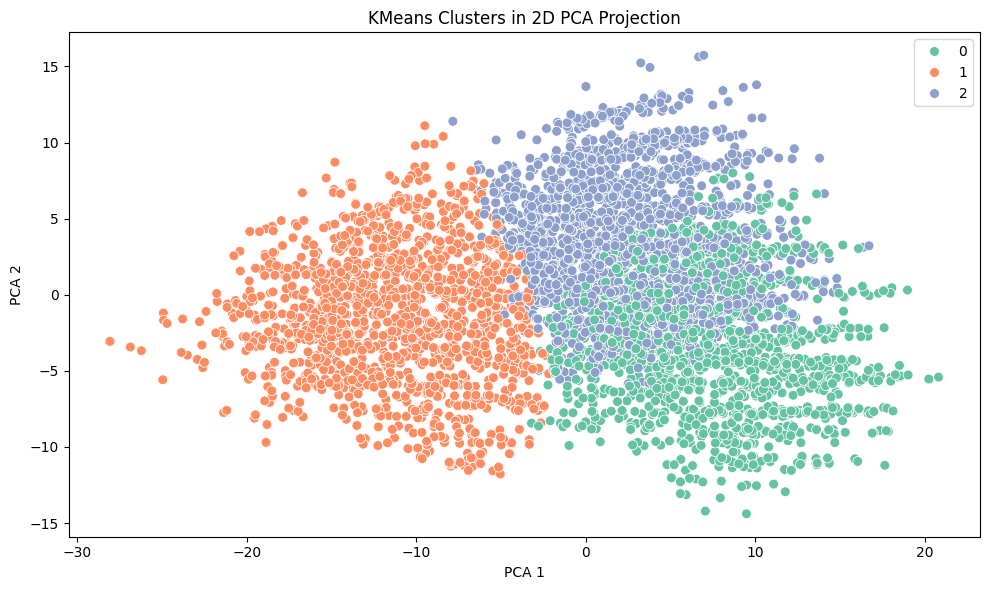

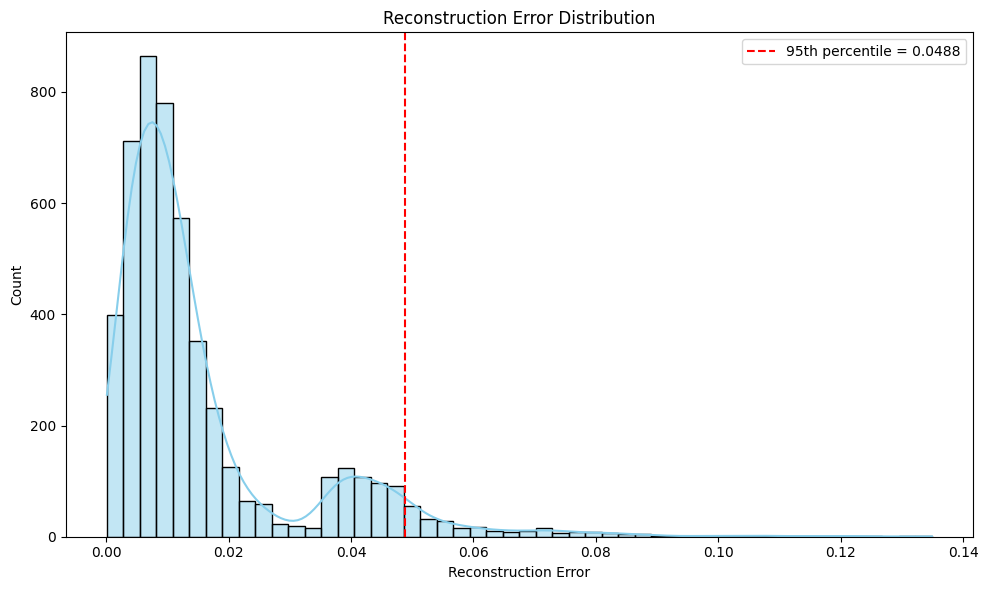


Cluster Feature Summary:
        recovery_time_(days)       paid_ransom       data_encrypted        \
                        mean count        mean count           mean count   
cluster                                                                     
0                      46.15  1547        0.47  1547           0.87  1547   
1                      42.43  1473        0.51  1473           0.85  1473   
2                      42.88  1980        0.50  1980           0.83  1980   

        backup_compromised        
                      mean count  
cluster                           
0                     0.63  1547  
1                     0.64  1473  
2                     0.64  1980  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# 1. Load Dataset
df = pd.read_csv('Healthcare Ransomware Dataset.csv')
df.drop(columns=['id', 'attack_date'], inplace=True)

# 2. Encode & Normalize
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols)

scaler = MinMaxScaler()
df_encoded[df_encoded.columns] = scaler.fit_transform(df_encoded[df_encoded.columns])

X = df_encoded.astype('float32').values

# 3. Train-Test Split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# 4. Build Autoencoder
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
latent = Dense(8, activation='relu', name='latent_layer')(x)
x = Dense(16, activation='relu')(latent)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(input_dim, activation='sigmoid')(x)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# 5. Train Autoencoder
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

# 6. Anomaly Detection (on Full Data)
X_pred = autoencoder.predict(X)
reconstruction_errors = np.mean(np.square(X - X_pred), axis=1)
thresh = np.percentile(reconstruction_errors, 95)
anomalies = (reconstruction_errors > thresh).astype(int)

# 7. Encode Latent Features
encoder = Model(inputs=input_layer, outputs=latent)
encoded_data = encoder.predict(X)

# 8. Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(encoded_data)
sil_score = silhouette_score(encoded_data, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

# 9. Add Results Back to DataFrame
df_results = df.copy()
df_results['anomaly'] = anomalies
df_results['cluster'] = clusters

# 10. Visualizations
pca = PCA(n_components=2)
reduced = pca.fit_transform(encoded_data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set2', s=50)
plt.title('KMeans Clusters in 2D PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue')
plt.axvline(thresh, color='red', linestyle='--', label=f'95th percentile = {thresh:.4f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()

# 11. Cluster Summary
summary = df_results.groupby('cluster')[[
    'recovery_time_(days)', 'paid_ransom', 'data_encrypted', 'backup_compromised'
]].agg(['mean', 'count'])
print("\nCluster Feature Summary:")
print(summary.round(2))

# 12. Save Output
df_results.to_csv('ransomware_cluster_results.csv', index=False)
np.save('latent_features.npy', encoded_data)

<ipython-input-3-c7fa3f3ad846>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_labels, y=cluster_counts.values, palette='Set2')


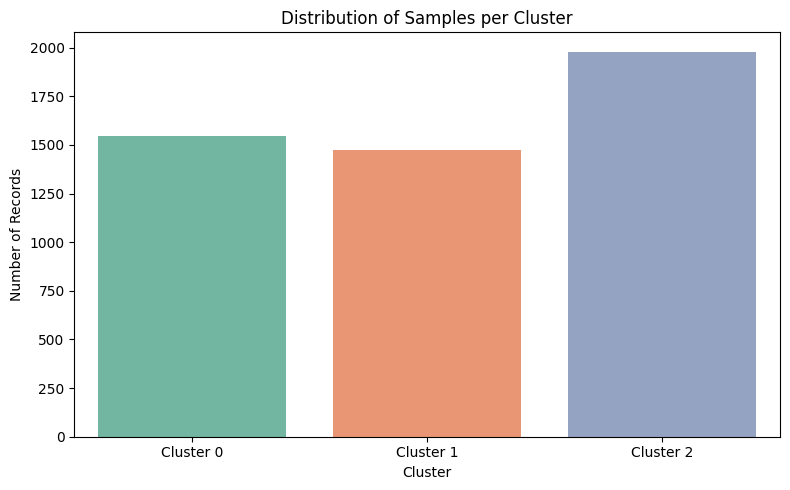

In [ ]:
plt.figure(figsize=(8, 5))
cluster_counts = df_results['cluster'].value_counts().sort_index()
cluster_labels = [f'Cluster {i}' for i in cluster_counts.index]

sns.barplot(x=cluster_labels, y=cluster_counts.values, palette='Set2')
plt.title('Distribution of Samples per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()